In [9]:
# -*- coding: utf-8 -*-

"""
EVCで変換する.
詳細 : https://pdfs.semanticscholar.org/cbfe/71798ded05fb8bf8674580aabf534c4dbb8bc.pdf

Converting by EVC.
Check detail : https://pdfs.semanticscholar.org/cbfe/71798ded05fb8bf8674580abf534c4dbb8bc.pdf
"""

'\nEVCで変換する.\n詳細 : https://pdfs.semanticscholar.org/cbfe/71798ded05fb8bf8674580aabf534c4dbb8bc.pdf\n\nConverting by EVC.\nCheck detail : https://pdfs.semanticscholar.org/cbfe/71798ded05fb8bf8674580abf534c4dbb8bc.pdf\n'

In [10]:
from __future__ import division, print_function

import os
from shutil import rmtree
import argparse
import glob
import pickle
import time

import numpy as np
from numpy.linalg import norm 
from sklearn.decomposition import PCA
from sklearn.mixture import GMM # sklearn 0.20.0から使えない
from sklearn.preprocessing import StandardScaler
import scipy.signal
import scipy.sparse

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
seaborn.set(style="dark")
plt.rcParams['figure.figsize'] = (16, 5)
import IPython 
from IPython.display import Audio 

import soundfile as sf
import wave 
import pyworld as pw
import librosa.display
import pysptk

from dtw import dtw
import warnings
warnings.filterwarnings('ignore')

In [11]:
EPSILON = 1e-8

class MFCC:
    """
    MFCC() : メル周波数ケプストラム係数(MFCC)を求めたり、MFCCからスペクトルに変換したりするクラス.
    動的特徴量(delta)が実装途中.
    ref : http://aidiary.hatenablog.com/entry/20120225/1330179868
    """
    
    
    def __init__(self, frequency, nfft=1026, dimension=24, channels=24):
        """
        各種パラメータのセット
        nfft : FFTのサンプル点数
        frequency : サンプリング周波数
        dimension : MFCC次元数
        channles : メルフィルタバンクのチャンネル数(dimensionに依存)
        fscale : 周波数スケール軸
        filterbankl, fcenters : フィルタバンク行列, フィルタバンクの頂点(?)
        """
        self.nfft = nfft
        self.frequency = frequency
        self.dimension = dimension
        self.channels = channels
        self.fscale = np.fft.fftfreq(self.nfft, d = 1.0 / self.frequency)[: int(self.nfft / 2)]
        self.filterbank, self.fcenters = self.melFilterBank()
    
    def hz2mel(self, f):
        """
        周波数からメル周波数に変換
        """
        return 1127.01048 * np.log(f / 700.0 + 1.0)
    
    def mel2hz(self, m):
        """
        メル周波数から周波数に変換
        """     
        return 700.0 * (np.exp(m / 1127.01048) - 1.0)

    def melFilterBank(self):
        """
        メルフィルタバンクを生成する
        """      
        fmax = self.frequency / 2
        melmax = self.hz2mel(fmax)
        nmax = int(self.nfft / 2)
        df = self.frequency / self.nfft
        dmel = melmax / (self.channels + 1)
        melcenters = np.arange(1, self.channels + 1) * dmel
        fcenters = self.mel2hz(melcenters)
        indexcenter = np.round(fcenters / df)
        indexstart = np.hstack(([0], indexcenter[0:self.channels - 1]))
        indexstop = np.hstack((indexcenter[1:self.channels], [nmax]))

        filterbank = np.zeros((self.channels, nmax))
        for c in np.arange(0, self.channels):
            increment = 1.0 / (indexcenter[c] - indexstart[c])
            # np,int_ は np.arangeが[0. 1. 2. ..]となるのをintにする
            for i in np.int_(np.arange(indexstart[c], indexcenter[c])):
                filterbank[c, i] = (i - indexstart[c]) * increment
            decrement = 1.0 / (indexstop[c] - indexcenter[c])
            # np,int_ は np.arangeが[0. 1. 2. ..]となるのをintにする
            for i in np.int_(np.arange(indexcenter[c], indexstop[c])):
                filterbank[c, i] = 1.0 - ((i - indexcenter[c]) * decrement)

        return filterbank, fcenters
    
    def mfcc(self, spectrum):
        """
        スペクトルからMFCCを求める.
        """
        mspec = []
        mspec = np.log10(np.dot(spectrum, self.filterbank.T))
        mspec = np.array(mspec)
        
        return scipy.fftpack.realtransforms.dct(mspec, type=2, norm="ortho", axis=-1)
    
    def delta(self, mfcc):
        """
        MFCCから動的特徴量を求める.
        現在は,求める特徴量フレームtをt-1とt+1の平均としている.
        """
        mfcc = np.concatenate([
            [mfcc[0]], 
            mfcc, 
            [mfcc[-1]]
        ]) # 最初のフレームを最初に、最後のフレームを最後に付け足す
        delta = None
        for i in range(1, mfcc.shape[0] - 1):
            slope = (mfcc[i+1] - mfcc[i-1]) / 2
            if delta is None:
                delta = slope
            else:
                delta = np.vstack([delta, slope])
        return delta
    
    def imfcc(self, mfcc, spectrogram):
        """
        MFCCからスペクトルを求める.
        """
        im_sp = np.array([])
        for i in range(mfcc.shape[0]):
            mfcc_s = np.hstack([mfcc[i], [0] * (self.channels - self.dimension)])
            mspectrum = scipy.fftpack.idct(mfcc_s, norm='ortho')
            # splrep はスプライン補間のための補間関数を求める
            tck = scipy.interpolate.splrep(self.fcenters, np.power(10, mspectrum))
            # splev は指定座標での補間値を求める
            im_spectrogram = scipy.interpolate.splev(self.fscale, tck)
            im_sp = np.concatenate((im_sp, im_spectrogram), axis=0)
            
        return im_sp.reshape(spectrogram.shape)
            
    def trim_zeros_frames(x, eps=1e-7):
        """
        無音区間を取り除く.
        """
        T, D = x.shape
        s = np.sum(np.abs(x), axis=1)
        s[s < 1e-7] = 0.
        return x[s > eps]

In [12]:
def analyse_by_world_with_harverst(x, fs, fftl=1024, shiftms=5.0, minf0=40.0, maxf0=500.0):
    """
    WORLD音声分析合成器で基本周波数F0,スペクトル包絡,非周期成分を求める.
    基本周波数F0についてはharvest法により,より精度良く求める.
    """
    #f0, time_axis = pw.harvest(x, fs, frame_period=shiftms)
    f0, time_axis = pw.harvest(x, fs, f0_floor=minf0, f0_ceil=maxf0, frame_period=shiftms)
    spc = pw.cheaptrick(x, f0, time_axis, fs, fft_size=fftl)
    ap = pw.d4c(x, f0, time_axis, fs, fft_size=fftl)
    
    # 4 Harvest with F0 refinement (using Stonemask)
    """
    frame_period = 5
    _f0, t = pw.harvest(x, fs, frame_period=frame_period)
    f0 = pw.stonemask(x, _f0, t, fs)
    sp = pw.cheaptrick(x, f0, t, fs)
    ap = pw.d4c(x, f0, t, fs)
    """
    
    return f0, spc, ap

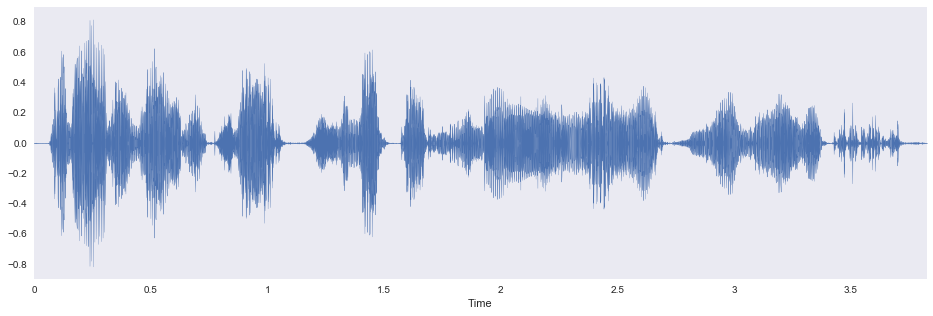

In [13]:
frame_length = 1024
hop_length = 80

path = 'utterance/'
file_name = 'mA01'
syn = '.wav'
name = path + file_name + syn

x, fs = sf.read(name)
assert fs == 16000

librosa.display.waveplot(x, sr=fs)
Audio(x, rate=fs)

In [14]:
f0, sp, ap = analyse_by_world_with_harverst(x, fs)

mfcc = MFCC(fs)
mf = mfcc.mfcc(sp)
mf_t = mf.T
plt.plot(mf_t[0], linewidth=2, label="mfcc sprocket")
plt.xlim(0, len(mf_t[0]))
plt.legend(prop={'size': 13})
plt.savefig(path +'mfcc_spr_' + file_name + '.png', format='png', dpi=300)
plt.close()

In [15]:
spc = mfcc.imfcc(mf, sp)
sp_t = sp.T
spc_t = spc.T
plt.plot(sp_t[0], linewidth=2, label="spec trajectry by WORLD")
plt.plot(spc_t[0], linewidth=2, label="spec trajectry from mfcc")
plt.xlim(0, len(sp_t[0]))
plt.legend(prop={'size': 13})
plt.savefig(path +'mc2sp_spr_' + file_name + '.png', format='png', dpi=300)
plt.close()

In [16]:
wav = pw.synthesize(f0, spc, ap, fs)
librosa.display.waveplot(wav, sr=fs)
plt.savefig(path +'mfcc2sp_wav_spr_' + file_name + '.png', format='png', dpi=300)
plt.close()
Audio(wav, rate=fs)
sf.write(path + 'mfcc2sp_spr_' +file_name + '.wav', wav, fs)